# Fully matched efficiency plots

## Initialise

In [176]:
import h5py
import awkward as ak
import vector
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
from matplotlib.colors import LogNorm
hep.style.use(hep.style.ROOT)
mpl.rcParams['figure.dpi'] = 50
vector.register_awkward()

In [177]:
df = h5py.File('./SPANet/0903_output_v5_matched.h5','r')
df_input = h5py.File('./SPANet/data/tth_matched_2.h5','r')
#fields = ['pt','eta','phi','btag']
#jets = ak.zip({
#    f: df["INPUTS"]["Source"][f][()] for f in fields
#}, with_name="Momentum4D")
#jets["m"] = np.zeros_like(jets.pt)
#jets[0].tolist()

In [178]:
df_jets = ak.from_parquet("/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_v6.parquet")
(jets,
partons_matched,
partons,
generator_info,
lepton_partons,
lepton_reco, 
met
) = ak.unzip(df_jets)
jets = ak.with_name(jets, name="Momentum4D")

In [179]:
# Get fully matched jets from df_jets
mask_fullymatched = ak.sum(jets.matched == True, axis=1)==7
jets = jets[jets.matched == True]
higgs = jets[jets.prov == 1]
jets = jets[ak.num(higgs) == 2]

w_or_t_jets = jets[(jets.prov == 5)|(jets.prov == 2)]
jets = jets[ak.num(w_or_t_jets) == 3]

lep_top = jets[jets.prov == 3]
jets = jets[ak.num(lep_top) == 1]

In [45]:
def get_leptop_arrays(n, njets, mode="partial"):

    # Leptonic top jets
    t2_b_pred = ak.Array(df["TARGETS"]["t2"]["b"][()])
    t2_b_pred = ak.unflatten(t2_b_pred, ak.ones_like(t2_b_pred))

    t2_b_true = ak.Array(df_input["TARGETS"]["t2"]["b"][()])
    t2_b_true = ak.unflatten(t2_b_true, ak.ones_like(t2_b_true))
    
    leptop_index_pred = t2_b_pred
    leptop_index_true = t2_b_true
    
    if mode == "partial":
        leptop_index_pred = leptop_index_pred[ak.num(jets)==n]
        leptop_index_true = leptop_index_true[ak.num(jets)==n]

    leptop_jet_pred = njets[leptop_index_pred]
    leptop_jet_true = njets[leptop_index_true]

    mask = (leptop_jet_true == leptop_jet_pred)
    leptop_pred_correct = leptop_jet_pred[mask] # correctly predicted jets
    leptop_pred_wrong = leptop_jet_pred[~mask] # wrongly predicted jets

    leptop_pred_correct = leptop_pred_correct[ak.num(leptop_pred_correct)>0]
    leptop_pred_wrong = leptop_pred_wrong[ak.num(leptop_pred_wrong)>0]

    return leptop_pred_correct, leptop_pred_wrong

def get_higgs_arrays(n, njets, mode="partial"):
    
    H_b1_true = ak.Array(df_input["TARGETS"]["h"]["b1"][()])
    H_b2_true = ak.Array(df_input["TARGETS"]["h"]["b2"][()])

    H_b1_true = ak.unflatten(H_b1_true, ak.ones_like(H_b1_true))
    H_b2_true = ak.unflatten(H_b2_true, ak.ones_like(H_b2_true))

    H_b1_pred = ak.Array(df["TARGETS"]["h"]["b1"][()])
    H_b2_pred = ak.Array(df["TARGETS"]["h"]["b2"][()])
    
    H_b1_pred = ak.unflatten(H_b1_pred, ak.ones_like(H_b1_pred))
    H_b2_pred = ak.unflatten(H_b2_pred, ak.ones_like(H_b2_pred))
 
    higgs_index_true = ak.concatenate((H_b1_true, H_b2_true), axis=1)
    higgs_index_pred = ak.concatenate((H_b1_pred, H_b2_pred), axis=1)
    
    if mode == "partial":
        higgs_index_true = higgs_index_true[ak.num(jets)==n]
        higgs_index_pred = higgs_index_pred[ak.num(jets)==n]

    higgs_jet_true = njets[higgs_index_true]
    higgs_jet_pred = njets[higgs_index_pred]
        
    mask = (higgs_jet_true == higgs_jet_pred)
    higgs_pred_correct = higgs_jet_pred[mask] # correctly predicted jets
    higgs_pred_wrong = higgs_jet_pred[~mask] # wrongly predicted jets

    higgs_pred_correct = higgs_pred_correct[ak.num(higgs_pred_correct)==2]
    higgs_pred_wrong = higgs_pred_wrong[ak.num(higgs_pred_wrong)>0]

    return higgs_pred_correct, higgs_pred_wrong

def get_hadtop_arrays(n, njets, mode="partial"):
    
    t1_q1_true = ak.Array(df_input["TARGETS"]["t1"]["q1"][()])
    t1_q2_true = ak.Array(df_input["TARGETS"]["t1"]["q2"][()])
    t1_b_true = ak.Array(df_input["TARGETS"]["t1"]["b"][()])

    t1_q1_true = ak.unflatten(t1_q1_true, ak.ones_like(t1_q1_true))
    t1_q2_true = ak.unflatten(t1_q2_true, ak.ones_like(t1_q2_true))
    t1_b_true = ak.unflatten(t1_b_true, ak.ones_like(t1_b_true))
    
    t1_q1_pred = ak.Array(df["TARGETS"]["t1"]["q1"][()])
    t1_q2_pred = ak.Array(df["TARGETS"]["t1"]["q2"][()])
    t1_b_pred = ak.Array(df["TARGETS"]["t1"]["b"][()])
    
    t1_q1_pred = ak.unflatten(t1_q1_pred, ak.ones_like(t1_q1_pred))
    t1_q2_pred = ak.unflatten(t1_q2_pred, ak.ones_like(t1_q2_pred))
    t1_b_pred = ak.unflatten(t1_b_pred, ak.ones_like(t1_b_pred))
 
    hadtop_index_true = ak.concatenate((t1_q1_true, t1_q2_true, t1_b_true), axis=1)
    hadtop_index_pred = ak.concatenate((t1_q1_pred, t1_q2_pred, t1_b_pred), axis=1)
    
    if mode == "partial":
        hadtop_index_true = hadtop_index_true[ak.num(jets)==n]
        hadtop_index_pred = hadtop_index_pred[ak.num(jets)==n]

    hadtop_jet_true = njets[hadtop_index_true]
    hadtop_jet_pred = njets[hadtop_index_pred]
        
    mask = (hadtop_jet_true == hadtop_jet_pred)
    hadtop_pred_correct = hadtop_jet_pred[mask] # correctly predicted jets
    hadtop_pred_wrong = hadtop_jet_pred[~mask] # wrongly predicted jets

    hadtop_pred_correct = hadtop_pred_correct[ak.num(hadtop_pred_correct)==3]
    hadtop_pred_wrong = hadtop_pred_wrong[ak.num(hadtop_pred_wrong)>0]

    return hadtop_pred_correct, hadtop_pred_wrong

def calculate_efficiency(particle, n, njets, mode="partial"):
    if particle == "h":
        pred_correct, pred_wrong = get_higgs_arrays(n, njets, mode)
    if particle == "t1":
        pred_correct, pred_wrong = get_hadtop_arrays(n, njets, mode)
    if particle == "t2":
        pred_correct, pred_wrong = get_leptop_arrays(n, njets, mode)
    print(f"\nNumber of correctly predicted within {n} jets is {len(pred_correct)}")
    print(f"Number of wrongly predicted within {n} jets is {len(pred_wrong)}")
    print(f"Total within {n} jets is {len(njets)}")
    
    purity = len(pred_correct)/len(njets)
    print(f"{n}-jet efficiency is {purity:.3f}")
    
    return pred_correct, pred_wrong

Plot the efficiency for the different particles for different number of jets. This should be the same as the table, which is:

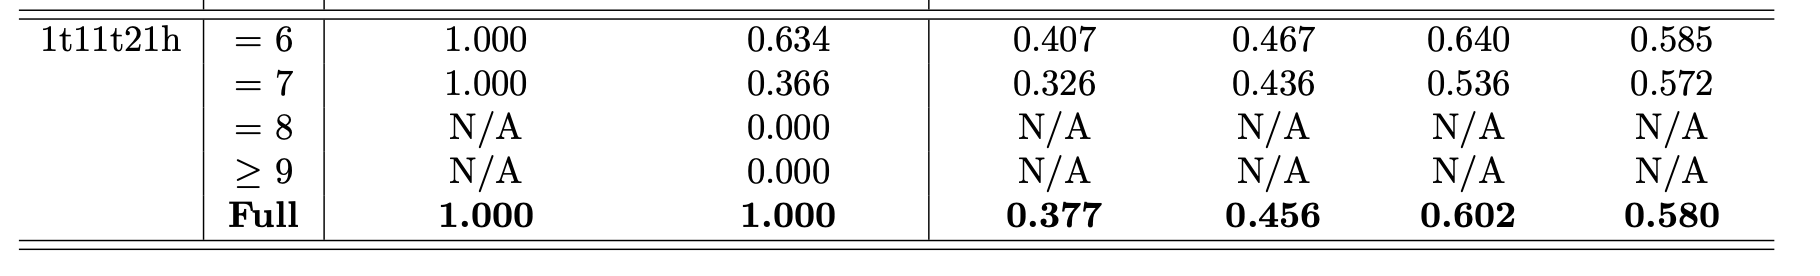

![matched_purities_v5.png](../matched_purities_v5.png)

## Leptonic top

In [49]:
purities = []

for n in range(6,8):
    pred_correct, pred_wrong = calculate_efficiency("t2", n, jets[ak.num(jets)==n])
    purity = len(pred_correct)/(len(pred_correct)+len(pred_wrong))
    purities.append(purity)
    
n = "all"
pred_correct, pred_wrong = calculate_efficiency("t2", n, jets, mode="full")
purity = len(pred_correct)/(len(pred_correct)+len(pred_wrong))
purities.append(purity)

leptop_purities = purities


Number of correctly predicted within 6 jets is 25168
Number of wrongly predicted within 6 jets is 17862
Total within 6 jets is 43030
6-jet efficiency is 0.585

Number of correctly predicted within 7 jets is 14222
Number of wrongly predicted within 7 jets is 10624
Total within 7 jets is 24846
7-jet efficiency is 0.572

Number of correctly predicted within all jets is 39390
Number of wrongly predicted within all jets is 28486
Total within all jets is 67876
all-jet efficiency is 0.580


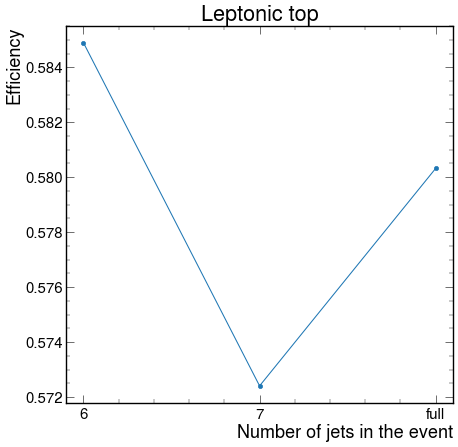

In [38]:
n = [6,7,"full"]
plt.plot(n, purities, marker='o')
plt.xlabel("Number of jets in the event")
plt.ylabel("Efficiency")
plt.title("Leptonic top")
plt.show()

## Higgs

In [50]:
purities = []

for n in range(6,8):
    pred_correct, pred_wrong = calculate_efficiency("h", n, jets[ak.num(jets)==n])
    purity = len(pred_correct)/(len(pred_correct)+len(pred_wrong))
    purities.append(purity)
    
n = "all"
pred_correct, pred_wrong = calculate_efficiency("h", n, jets, mode="full")
purity = len(pred_correct)/(len(pred_correct)+len(pred_wrong))
purities.append(purity)

higgs_purities = purities


Number of correctly predicted within 6 jets is 20112
Number of wrongly predicted within 6 jets is 22918
Total within 6 jets is 43030
6-jet efficiency is 0.467

Number of correctly predicted within 7 jets is 10835
Number of wrongly predicted within 7 jets is 14011
Total within 7 jets is 24846
7-jet efficiency is 0.436

Number of correctly predicted within all jets is 30947
Number of wrongly predicted within all jets is 36929
Total within all jets is 67876
all-jet efficiency is 0.456


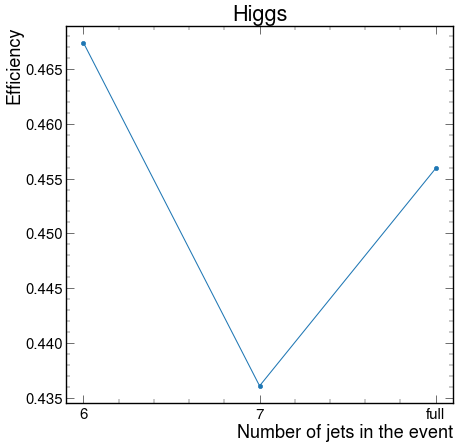

In [41]:
n = [6,7,"full"]
plt.plot(n, purities, marker='o')
plt.xlabel("Number of jets in the event")
plt.ylabel("Efficiency")
plt.title("Higgs")
plt.show()

## Hadronic top

In [51]:
purities = []

for n in range(6,8):
    pred_correct, pred_wrong = calculate_efficiency("t1", n, jets[ak.num(jets)==n])
    purity = len(pred_correct)/(len(pred_correct)+len(pred_wrong))
    purities.append(purity)
    
n = "all"
pred_correct, pred_wrong = calculate_efficiency("t1", n, jets, mode="full")
purity = len(pred_correct)/(len(pred_correct)+len(pred_wrong))
purities.append(purity)

hadtop_purities = purities


Number of correctly predicted within 6 jets is 27555
Number of wrongly predicted within 6 jets is 15475
Total within 6 jets is 43030
6-jet efficiency is 0.640

Number of correctly predicted within 7 jets is 13315
Number of wrongly predicted within 7 jets is 11531
Total within 7 jets is 24846
7-jet efficiency is 0.536

Number of correctly predicted within all jets is 40870
Number of wrongly predicted within all jets is 27006
Total within all jets is 67876
all-jet efficiency is 0.602


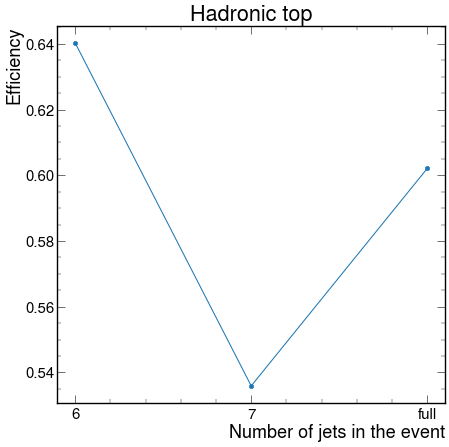

In [47]:
n = [6,7,"full"]
plt.plot(n, purities, marker='o')
plt.xlabel("Number of jets in the event")
plt.ylabel("Efficiency")
plt.title("Hadronic top")
plt.show()

## All efficiencies

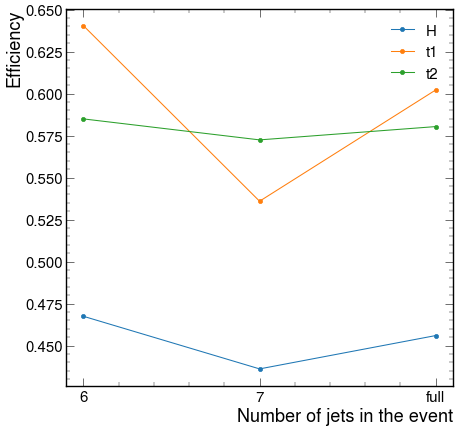

In [54]:
n = [6,7,"full"]
plt.plot(n, higgs_purities, marker='o', label="H")
plt.plot(n, hadtop_purities, marker='o', label="t1")
plt.plot(n, leptop_purities, marker='o', label="t2")
plt.xlabel("Number of jets in the event")
plt.ylabel("Efficiency")
plt.legend()
plt.show()

## Higgs efficiency by Higgs pt

In [463]:
H_b1_true = ak.Array(df_input["TARGETS"]["h"]["b1"][()])
H_b2_true = ak.Array(df_input["TARGETS"]["h"]["b2"][()])

H_b1_true = ak.unflatten(H_b1_true, ak.ones_like(H_b1_true))
H_b2_true = ak.unflatten(H_b2_true, ak.ones_like(H_b2_true))

H_b1_pred = ak.Array(df["TARGETS"]["h"]["b1"][()])
H_b2_pred = ak.Array(df["TARGETS"]["h"]["b2"][()])

H_b1_pred = ak.unflatten(H_b1_pred, ak.ones_like(H_b1_pred))
H_b2_pred = ak.unflatten(H_b2_pred, ak.ones_like(H_b2_pred))

higgs_index_true = ak.concatenate((H_b1_true, H_b2_true), axis=1)
higgs_index_pred = ak.concatenate((H_b1_pred, H_b2_pred), axis=1)

higgs_jet_true = jets[higgs_index_true]
higgs_jet_pred = jets[higgs_index_pred]

In [464]:
higgs_jet_true

<MomentumArray4D [[{pt: 126, eta: 2.37, ... prov: 1}]] type='67876 * var * Momen...'>

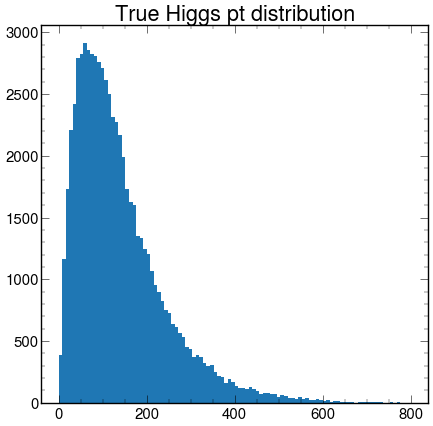

In [465]:
plt.hist((higgs_jet_true[:,0] + higgs_jet_true[:,1]).pt, bins=100, range=(0,800))
plt.title("True Higgs pt distribution");

In [466]:
higgs_true_pt = (higgs_jet_true[:,0] + higgs_jet_true[:,1]).pt
higgs_pred_pt = (higgs_jet_pred[:,0] + higgs_jet_pred[:,1]).pt
higgs_true_pt

<Array [166, 161, 189, 394, ... 276, 209, 106] type='67876 * float32'>

In [467]:
higgs_pred_pt

<Array [166, 161, 108, 103, ... 276, 99.2, 106] type='67876 * float32'>

In [432]:
def find_bin(value, bins):
    """ bins is a list of tuples, like [(0,20), (20, 40), (40, 60)],
        binning returns the smallest index i of bins so that
        bin[i][0] <= value < bin[i][1]
    """
    for i in range(0, len(bins)):
        if bins[i][0] <= value < bins[i][1]:
            return i
    return -1

def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    bins = []
    for low in range(lower_bound, lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

In [447]:
def pt_efficiency(true_pt, pred_pt, nbins, binwidth):
    
    # Bin the array of predicted pts
    data = pd.DataFrame({"pt": pred_pt})

    bins = create_bins(lower_bound=0, width=binwidth, quantity=nbins)
    bin_means = []
    for i in range(len(bins)):
        bin_means.append((bins[i][0] + bins[i][1])/2)

    bins = pd.IntervalIndex.from_tuples(bins)
    data['pt_bin'] = pd.cut(data['pt'], bins=bins)
    
    # Find all counts (correctly and wrongly predicted -- denominator of efficiency)
    a = data['pt_bin'].value_counts(sort=False)
    a.index = a.index.astype(str)
    a = a.to_dict()
    all_counts = np.array(list(a.values()))
    
    # Construct correctly predicted and wrongly predicted jet pts
    mask = (true_pt == pred_pt)
    #pred_correct = pred_pt[mask] # correctly predicted jets
    #pred_wrong = pred_pt[~mask] # wrongly predicted jets
    
    # Find counts of correctly predicted events
    data['correct'] = mask
    data = data[data['correct']==True]
    c = data['pt_bin'].value_counts(sort=False)
    c.index = c.index.astype(str)
    c = c.to_dict()
    correct_counts = np.array(list(c.values()))

    # Find the efficiency for each interval
    bin_efficiency = np.zeros(len(correct_counts))

    for i in range(len(all_counts)):
        if all_counts[i] > 0: # disregard empty bins and assign 0 efficiency to them
            bin_efficiency[i] = correct_counts[i]/all_counts[i]
        else:
            bin_efficiency[i] = 0
            
    return bin_means, bin_efficiency

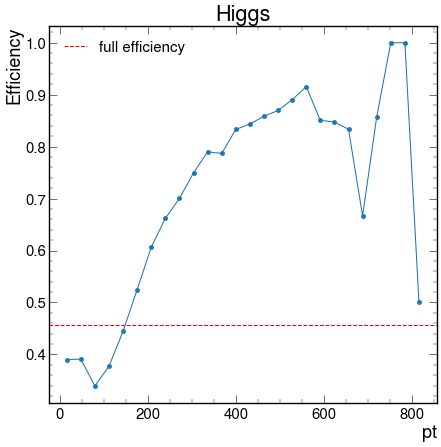

In [644]:
bin_means, bin_efficiency = pt_efficiency(higgs_true_pt, higgs_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.axhline(0.456, label="full efficiency", color='r', linestyle="--")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Higgs")
plt.legend()
plt.show()

Normalise somehow? because very misleading -- overall efficiency only 0.456

Instead of dividing by counts in that pt bin -- divide by total counts

In [469]:
total_counts = len(higgs_pred_pt)

In [498]:
# Bin the array of predicted pts
data = pd.DataFrame({"pt": higgs_pred_pt})

bins = create_bins(lower_bound=0, width=32, quantity=25)
bin_means = []
for i in range(len(bins)):
    bin_means.append((bins[i][0] + bins[i][1])/2)

bins = pd.IntervalIndex.from_tuples(bins)
data['pt_bin'] = pd.cut(data['pt'], bins=bins)

# Construct correctly predicted and wrongly predicted jet pts
mask = (higgs_true_pt == higgs_pred_pt)

# Find counts of correctly predicted events
data['correct'] = mask
data = data[data['correct']==True]
c = data['pt_bin'].value_counts(sort=False)
c.index = c.index.astype(str)
c = c.to_dict()
correct_counts = np.array(list(c.values()))

# Find the efficiency for each interval
bin_efficiency = np.zeros(len(correct_counts))

for i in range(len(correct_counts)):
    bin_efficiency[i] = correct_counts[i]/total_counts

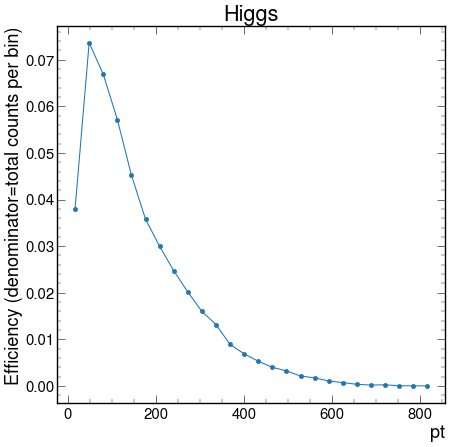

In [499]:
plt.plot(bin_means, bin_efficiency, marker='o')
plt.xlabel("pt")
plt.ylabel("Efficiency (denominator=total counts per bin)")
plt.title("Higgs")
plt.show()

In [493]:
print("CORRECT COUNTS IN EACH BIN")
data['pt_bin'].value_counts(sort=False) # THE CORRECT COUNTS IN EACH BIN

CORRECT COUNTS IN EACH BIN


(0, 32]       2579
(32, 64]      4998
(64, 96]      4538
(96, 128]     3880
(128, 160]    3070
(160, 192]    2429
(192, 224]    2034
(224, 256]    1680
(256, 288]    1369
(288, 320]    1086
(320, 352]     895
(352, 384]     606
(384, 416]     469
(416, 448]     361
(448, 480]     273
(480, 512]     220
(512, 544]     146
(544, 576]     119
(576, 608]      74
(608, 640]      50
(640, 672]      25
(672, 704]      14
(704, 736]      18
(736, 768]       4
(768, 800]       3
(800, 832]       2
Name: pt_bin, dtype: int64

In [500]:
data = pd.DataFrame({"pt": higgs_pred_pt})

bins = create_bins(lower_bound=0, width=32, quantity=25)
bin_means = []
for i in range(len(bins)):
    bin_means.append((bins[i][0] + bins[i][1])/2)

bins = pd.IntervalIndex.from_tuples(bins)
data['pt_bin'] = pd.cut(data['pt'], bins=bins)

a = data['pt_bin'].value_counts(sort=False)
a.index = a.index.astype(str)
a = a.to_dict()
all_counts = np.array(list(a.values()))

print("TOTAL COUNTS IN EACH BIN")
data['pt_bin'].value_counts(sort=False) # TOTAL COUNTS IN EACH BIN

TOTAL COUNTS IN EACH BIN


(0, 32]        6609
(32, 64]      12785
(64, 96]      13368
(96, 128]     10288
(128, 160]     6903
(160, 192]     4629
(192, 224]     3354
(224, 256]     2538
(256, 288]     1955
(288, 320]     1449
(320, 352]     1133
(352, 384]      770
(384, 416]      563
(416, 448]      428
(448, 480]      318
(480, 512]      253
(512, 544]      164
(544, 576]      130
(576, 608]       87
(608, 640]       59
(640, 672]       30
(672, 704]       21
(704, 736]       21
(736, 768]        4
(768, 800]        3
(800, 832]        4
Name: pt_bin, dtype: int64

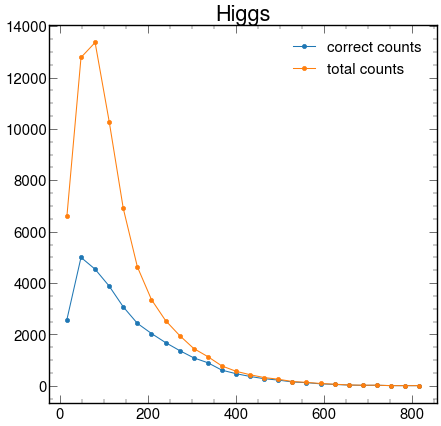

In [501]:
plt.plot(bin_means, correct_counts, marker='o', label="correct counts")
plt.plot(bin_means, all_counts, marker='o', label="total counts")
plt.title("Higgs")
plt.legend()
plt.show()

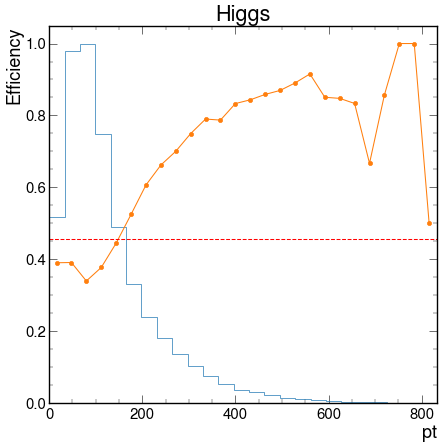

In [646]:
pred_pt = higgs_pred_pt[higgs_pred_pt <= 832]
pred_pt = pred_pt[pred_pt >= 0]
(counts, bins) = np.histogram(pred_pt, bins=25)
factor = 1/np.max(counts)
plt.hist(bins[:-1], bins, weights=factor*counts, histtype="step")
bin_means, bin_efficiency = pt_efficiency(higgs_true_pt, higgs_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Higgs")
plt.xlim(0,832)
plt.axhline(0.456, label="full efficiency", color='r', linestyle="--")
plt.show()

## Higgs efficiency by Higgs eta

In [450]:
higgs_true_eta = (higgs_jet_true[:,0] + higgs_jet_true[:,1]).eta
higgs_pred_eta = (higgs_jet_pred[:,0] + higgs_jet_pred[:,1]).eta

In [453]:
def eta_efficiency(true_eta, pred_eta, nbins, binwidth):
    
    # Bin the array of predicted etas
    data = pd.DataFrame({"eta": pred_eta})

    bins = create_bins(lower_bound=-4, width=binwidth, quantity=nbins)
    bin_means = []
    for i in range(len(bins)):
        bin_means.append((bins[i][0] + bins[i][1])/2)

    bins = pd.IntervalIndex.from_tuples(bins)
    data['eta_bin'] = pd.cut(data['eta'], bins=bins)
    
    # Find all counts (correctly and wrongly predicted -- denominator of efficiency)
    a = data['eta_bin'].value_counts(sort=False)
    a.index = a.index.astype(str)
    a = a.to_dict()
    all_counts = np.array(list(a.values()))
    
    # Construct correctly predicted and wrongly predicted jet pts
    mask = (true_eta == pred_eta)

    # Find counts of correctly predicted events
    data['correct'] = mask
    data = data[data['correct']==True]
    c = data['eta_bin'].value_counts(sort=False)
    c.index = c.index.astype(str)
    c = c.to_dict()
    correct_counts = np.array(list(c.values()))

    # Find the efficiency for each interval
    bin_efficiency = np.zeros(len(correct_counts))

    for i in range(len(all_counts)):
        if all_counts[i] > 0: # disregard empty bins and assign 0 efficiency to them
            bin_efficiency[i] = correct_counts[i]/all_counts[i]
        else:
            bin_efficiency[i] = 0
            
    return bin_means, bin_efficiency

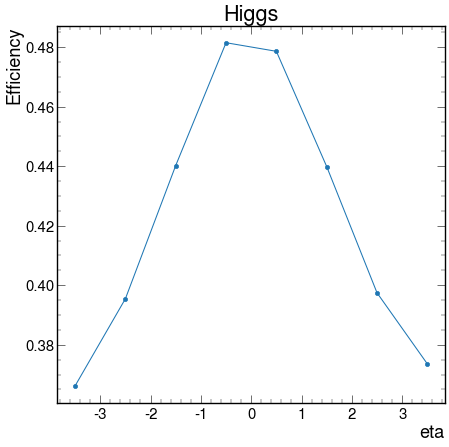

In [459]:
bin_means, bin_efficiency = eta_efficiency(higgs_true_eta, higgs_pred_eta, nbins=7, binwidth=1)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.xlabel("eta")
plt.ylabel("Efficiency")
plt.title("Higgs")
plt.show()

## Higgs quark efficiency by quark pt

In [510]:
H_b1_true = ak.Array(df_input["TARGETS"]["h"]["b1"][()])
H_b1_true = ak.unflatten(H_b1_true, ak.ones_like(H_b1_true))
H_b1_pred = ak.Array(df["TARGETS"]["h"]["b1"][()])
H_b1_pred = ak.unflatten(H_b1_pred, ak.ones_like(H_b1_pred))

H_b1_jet_true = jets[H_b1_true]
H_b1_jet_pred = jets[H_b1_pred]

b1_true_pt = H_b1_jet_true.pt
b1_pred_pt = H_b1_jet_pred.pt

b1_true_pt = ak.flatten(b1_true_pt)
b1_pred_pt = ak.flatten(b1_pred_pt)

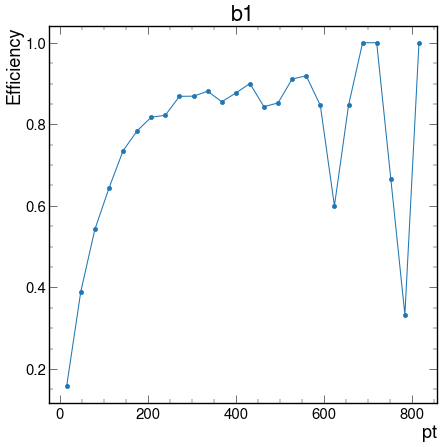

In [511]:
bin_means, bin_efficiency = pt_efficiency(b1_true_pt, b1_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("b1")
plt.show()

In [512]:
H_b2_true = ak.Array(df_input["TARGETS"]["h"]["b2"][()])
H_b2_true = ak.unflatten(H_b2_true, ak.ones_like(H_b2_true))
H_b2_pred = ak.Array(df["TARGETS"]["h"]["b2"][()])
H_b2_pred = ak.unflatten(H_b2_pred, ak.ones_like(H_b2_pred))

H_b2_jet_true = jets[H_b2_true]
H_b2_jet_pred = jets[H_b2_pred]

b2_true_pt = H_b2_jet_true.pt
b2_pred_pt = H_b2_jet_pred.pt

b2_true_pt = ak.flatten(b2_true_pt)
b2_pred_pt = ak.flatten(b2_pred_pt)

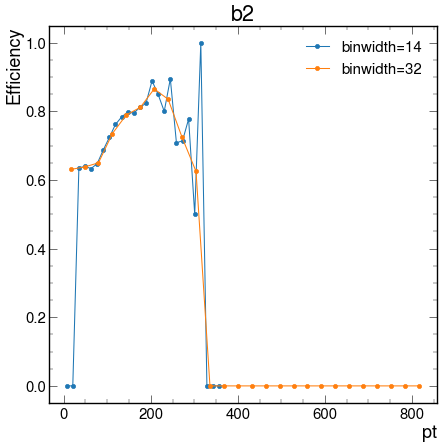

In [638]:
bin_means, bin_efficiency = pt_efficiency(b2_true_pt, b2_pred_pt, nbins=25, binwidth=14)
plt.plot(bin_means, bin_efficiency, marker='o', label="binwidth=14")
bin_means, bin_efficiency = pt_efficiency(b2_true_pt, b2_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o', label="binwidth=32")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("b2")
plt.legend()
plt.show()

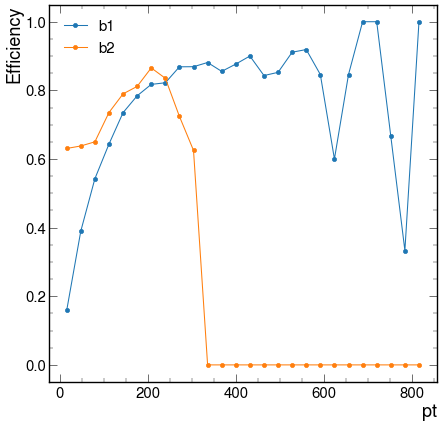

In [636]:
bin_means, bin_efficiency = pt_efficiency(b1_true_pt, b1_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o', label="b1")
bin_means, bin_efficiency = pt_efficiency(b2_true_pt, b2_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o', label="b2")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.legend()
plt.show()

Make sure correctly assigned are the case when b1 and b2 both assigned correctly

In [612]:
higgs_index_true = ak.concatenate((H_b1_true, H_b2_true), axis=1)
higgs_index_pred = ak.concatenate((H_b1_pred, H_b2_pred), axis=1)

higgs_jet_true = jets[higgs_index_true]
higgs_jet_pred = jets[higgs_index_pred]

higgs_pred_pt = (higgs_jet_pred[:,0] + higgs_jet_pred[:,1]).pt
higgs_true_pt = (higgs_jet_true[:,0] + higgs_jet_true[:,1]).pt

mask = (higgs_jet_true == higgs_jet_pred)
higgs_pred_correct = higgs_jet_pred[mask] # correctly predicted jets
higgs_pred_wrong = higgs_jet_pred[~mask] # wrongly predicted jets

higgs_pred_correct = higgs_pred_correct[ak.num(higgs_pred_correct)==2]
higgs_pred_wrong = higgs_pred_wrong[ak.num(higgs_pred_wrong)>0]

higgs_pred_correct_pt = (higgs_pred_correct[:,0] + higgs_pred_correct[:,1]).pt
higgs_true_correct_pt = (higgs_pred_correct[:,0] + higgs_pred_correct[:,1]).pt

In [607]:
mask2 = []
for i in range(len(mask)):
    mask2.append((mask[i,0] and mask[i,1]) == True)

In [616]:
binwidth = 32
nbins = 25
pred_pt = higgs_pred_pt
true_pt = higgs_true_pt
correct_pt = higgs_pred_correct_pt

# Bin the array of predicted pts
data = pd.DataFrame({"pt": pred_pt})

bins = create_bins(lower_bound=0, width=binwidth, quantity=nbins)
bin_means = []
for i in range(len(bins)):
    bin_means.append((bins[i][0] + bins[i][1])/2)

bins = pd.IntervalIndex.from_tuples(bins)
data['pt_bin'] = pd.cut(data['pt'], bins=bins)

# Find all counts (correctly and wrongly predicted -- denominator of efficiency)
a = data['pt_bin'].value_counts(sort=False)
a.index = a.index.astype(str)
a = a.to_dict()
all_counts = np.array(list(a.values()))

# Find counts of correctly predicted events
data['correct'] = mask2
data = data[data['correct']==True]
c = data['pt_bin'].value_counts(sort=False)
c.index = c.index.astype(str)
c = c.to_dict()
correct_counts = np.array(list(c.values()))

# Find the efficiency for each interval
bin_efficiency = np.zeros(len(correct_counts))

for i in range(len(all_counts)):
    if all_counts[i] > 0: # disregard empty bins and assign 0 efficiency to them
        bin_efficiency[i] = correct_counts[i]/all_counts[i]
    else:
        bin_efficiency[i] = 0


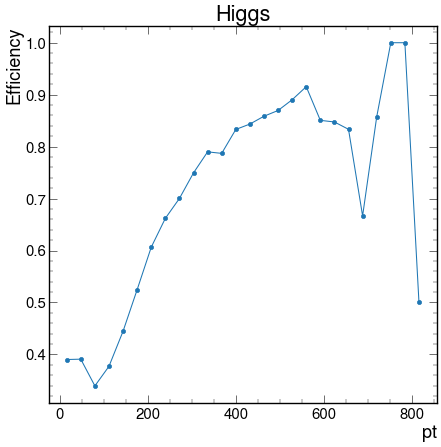

In [614]:
plt.plot(bin_means, bin_efficiency, marker='o')
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Higgs")
plt.show()

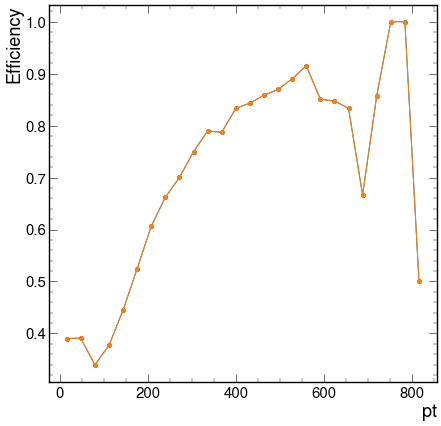

In [617]:
plt.plot(bin_means, bin_efficiency, marker='o')
bin_means, bin_efficiency = pt_efficiency(higgs_true_pt, higgs_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.show()

## Leptonic top efficiency by pt

In [648]:
t2_b_pred = ak.Array(df["TARGETS"]["t2"]["b"][()])
t2_b_pred = ak.unflatten(t2_b_pred, ak.ones_like(t2_b_pred))

t2_b_true = ak.Array(df_input["TARGETS"]["t2"]["b"][()])
t2_b_true = ak.unflatten(t2_b_true, ak.ones_like(t2_b_true))

leptop_index_pred = t2_b_pred
leptop_index_true = t2_b_true

leptop_jet_pred = jets[leptop_index_pred]
leptop_jet_true = jets[leptop_index_true]

leptop_pred_pt = leptop_jet_pred.pt
leptop_true_pt = leptop_jet_true.pt

leptop_pred_pt = ak.flatten(leptop_pred_pt)
leptop_true_pt = ak.flatten(leptop_true_pt)

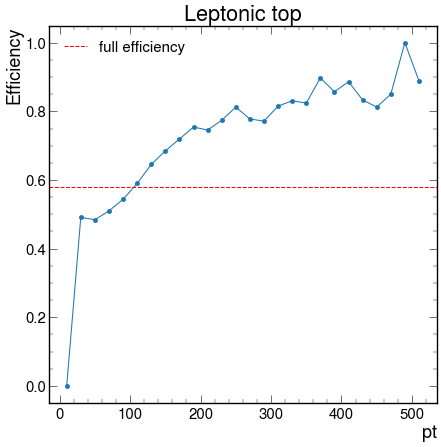

In [652]:
bin_means, bin_efficiency = pt_efficiency(leptop_true_pt, leptop_pred_pt, nbins=25, binwidth=20)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.axhline(0.580, label="full efficiency", color='r', linestyle="--")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Leptonic top")
plt.legend()
plt.show()

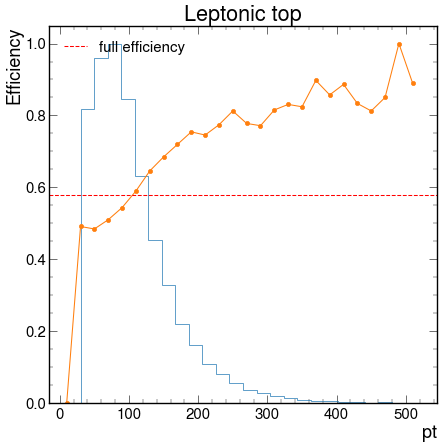

In [655]:
pred_pt = leptop_pred_pt[leptop_pred_pt <= 520]
pred_pt = pred_pt[pred_pt >= 0]
(counts, bins) = np.histogram(pred_pt, bins=25)
factor = 1/np.max(counts)
plt.hist(bins[:-1], bins, weights=factor*counts, histtype="step")

bin_means, bin_efficiency = pt_efficiency(leptop_true_pt, leptop_pred_pt, nbins=25, binwidth=20)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.axhline(0.580, label="full efficiency", color='r', linestyle="--")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Leptonic top")
plt.legend()
plt.show()

## Hadronic top efficiency by pt

In [657]:
t1_q1_true = ak.Array(df_input["TARGETS"]["t1"]["q1"][()])
t1_q2_true = ak.Array(df_input["TARGETS"]["t1"]["q2"][()])
t1_b_true = ak.Array(df_input["TARGETS"]["t1"]["b"][()])

t1_q1_true = ak.unflatten(t1_q1_true, ak.ones_like(t1_q1_true))
t1_q2_true = ak.unflatten(t1_q2_true, ak.ones_like(t1_q2_true))
t1_b_true = ak.unflatten(t1_b_true, ak.ones_like(t1_b_true))

t1_q1_pred = ak.Array(df["TARGETS"]["t1"]["q1"][()])
t1_q2_pred = ak.Array(df["TARGETS"]["t1"]["q2"][()])
t1_b_pred = ak.Array(df["TARGETS"]["t1"]["b"][()])

t1_q1_pred = ak.unflatten(t1_q1_pred, ak.ones_like(t1_q1_pred))
t1_q2_pred = ak.unflatten(t1_q2_pred, ak.ones_like(t1_q2_pred))
t1_b_pred = ak.unflatten(t1_b_pred, ak.ones_like(t1_b_pred))

hadtop_index_true = ak.concatenate((t1_q1_true, t1_q2_true, t1_b_true), axis=1)
hadtop_index_pred = ak.concatenate((t1_q1_pred, t1_q2_pred, t1_b_pred), axis=1)

hadtop_jet_true = jets[hadtop_index_true]
hadtop_jet_pred = jets[hadtop_index_pred]

hadtop_pred_pt = (hadtop_jet_pred[:,0] + hadtop_jet_pred[:,1] + hadtop_jet_pred[:,2]).pt
hadtop_true_pt = (hadtop_jet_true[:,0] + hadtop_jet_true[:,1] + hadtop_jet_true[:,2]).pt

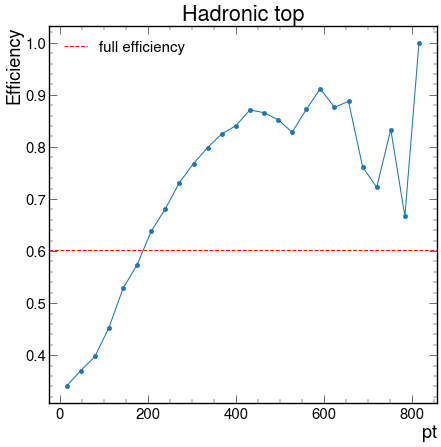

In [666]:
bin_means, bin_efficiency = pt_efficiency(hadtop_true_pt, hadtop_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.axhline(0.602, label="full efficiency", color='r', linestyle="--")
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Hadronic top")
plt.legend()
plt.show()

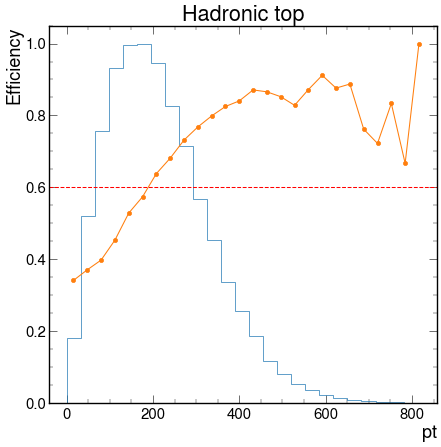

In [668]:
pred_pt = hadtop_pred_pt[hadtop_pred_pt <= 832]
pred_pt = pred_pt[pred_pt >= 0]
(counts, bins) = np.histogram(pred_pt, bins=25)
factor = 1/np.max(counts)
plt.hist(bins[:-1], bins, weights=factor*counts, histtype="step")

bin_means, bin_efficiency = pt_efficiency(hadtop_true_pt, hadtop_pred_pt, nbins=25, binwidth=32)
plt.plot(bin_means, bin_efficiency, marker='o')
plt.xlabel("pt")
plt.ylabel("Efficiency")
plt.title("Hadronic top")
plt.axhline(0.602, label="full efficiency", color='r', linestyle="--")
plt.show()

# Full dataset efficiency plots

## Initialise

In [55]:
df = h5py.File('./SPANet/1003_output_v5_full.h5','r')
df_input = h5py.File('./SPANet/data/tth.h5','r')

jets_input = ak.from_parquet("/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_v6.parquet")
(jets,
partons_matched,
partons,
generator_info,
lepton_partons,
lepton_reco, 
met
) = ak.unzip(jets_input)
jets = ak.with_name(jets, name="Momentum4D")

In [349]:
jets[0].tolist()

[{'pt': 68.3125,
  'eta': 0.8526611328125,
  'phi': 2.255859375,
  'btag': 0.9951171875,
  'm': 0.0,
  'matched': True,
  'prov': 2.0},
 {'pt': 58.03125,
  'eta': 1.462158203125,
  'phi': -0.42449951171875,
  'btag': 0.732421875,
  'm': 0.0,
  'matched': True,
  'prov': 3.0},
 {'pt': 40.4375,
  'eta': 1.4453125,
  'phi': -1.45703125,
  'btag': 0.0792236328125,
  'm': 0.0,
  'matched': False,
  'prov': -1.0},
 {'pt': 30.71875,
  'eta': 0.04489898681640625,
  'phi': 0.5386962890625,
  'btag': 0.49560546875,
  'm': 0.0,
  'matched': True,
  'prov': 4.0},
 {'pt': 30.421875,
  'eta': 2.32421875,
  'phi': 0.33026123046875,
  'btag': 0.04327392578125,
  'm': 0.0,
  'matched': True,
  'prov': 5.0}]

In [350]:
fields = ['pt','eta','phi','btag']
jets = ak.zip({
    f: df["INPUTS"]["Source"][f][()] for f in fields
}, with_name="Momentum4D")
jets["m"] = np.zeros_like(jets.pt)
jets[0].tolist()

[{'pt': 68.3125,
  'eta': 0.8526611328125,
  'phi': 2.255859375,
  'btag': 0.9951171875,
  'm': 0.0},
 {'pt': 58.03125,
  'eta': 1.462158203125,
  'phi': -0.42449951171875,
  'btag': 0.732421875,
  'm': 0.0},
 {'pt': 40.4375,
  'eta': 1.4453125,
  'phi': -1.45703125,
  'btag': 0.0792236328125,
  'm': 0.0},
 {'pt': 30.71875,
  'eta': 0.04489898681640625,
  'phi': 0.5386962890625,
  'btag': 0.49560546875,
  'm': 0.0},
 {'pt': 30.421875,
  'eta': 2.32421875,
  'phi': 0.33026123046875,
  'btag': 0.04327392578125,
  'm': 0.0},
 {'pt': 0.0, 'eta': 0.0, 'phi': 0.0, 'btag': 0.0, 'm': 0.0},
 {'pt': 0.0, 'eta': 0.0, 'phi': 0.0, 'btag': 0.0, 'm': 0.0},
 {'pt': 0.0, 'eta': 0.0, 'phi': 0.0, 'btag': 0.0, 'm': 0.0},
 {'pt': 0.0, 'eta': 0.0, 'phi': 0.0, 'btag': 0.0, 'm': 0.0},
 {'pt': 0.0, 'eta': 0.0, 'phi': 0.0, 'btag': 0.0, 'm': 0.0},
 {'pt': 0.0, 'eta': 0.0, 'phi': 0.0, 'btag': 0.0, 'm': 0.0},
 {'pt': 0.0, 'eta': 0.0, 'phi': 0.0, 'btag': 0.0, 'm': 0.0},
 {'pt': 0.0, 'eta': 0.0, 'phi': 0.0, 'btag': 

In [368]:
fields = ['pt','eta','phi','btag']
jets = ak.zip({
    f: df["INPUTS"]["Source"][f][()] for f in fields
}, with_name="Momentum4D")
jets["m"] = np.zeros_like(jets.pt)
jets[0].tolist()

leptop_full_pred_correct, leptop_full_pred_wrong = get_leptop_arrays(15, jets) # full jets

jets_input = ak.from_parquet("/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_v6.parquet")
(jets,
partons_matched,
partons,
generator_info,
lepton_partons,
lepton_reco, 
met
) = ak.unzip(jets_input)
jets = ak.with_name(jets, name="Momentum4D")

leptop_6_pred_correct, leptop_6_pred_wrong = get_leptop_arrays(6, jets[ak.num(jets)==6]) # 6-jet events
leptop_7_pred_correct, leptop_7_pred_wrong = get_leptop_arrays(7, jets[ak.num(jets)==7]) # 6-jet events

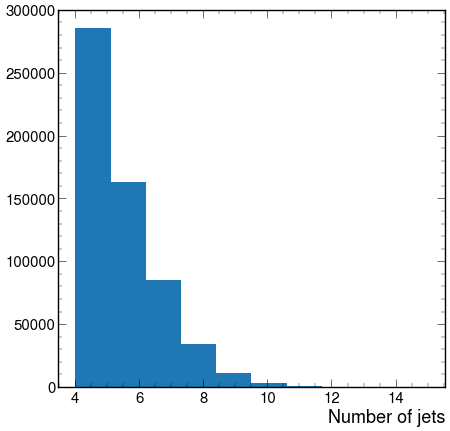

In [57]:
plt.hist(ak.num(jets))
plt.xlabel("Number of jets");

## Leptonic top

In [121]:
def get_leptop_arrays(n, njets, mode="partial"):

    # Leptonic top jets
    t2_b_pred = ak.Array(df["TARGETS"]["t2"]["b"][()])
    t2_b_pred = ak.unflatten(t2_b_pred, ak.ones_like(t2_b_pred))

    t2_b_true = ak.Array(df_input["TARGETS"]["t2"]["b"][()])
    t2_b_true = ak.unflatten(t2_b_true, ak.ones_like(t2_b_true))
    
    leptop_index_pred = t2_b_pred
    leptop_index_true = t2_b_true
    
    print(leptop_index_true)
    print(leptop_index_pred)
    print(len(leptop_index_true))
    print(len(leptop_index_pred))
    
    mask = (leptop_index_true != -1)
    leptop_index_true = leptop_index_true[mask]
    leptop_index_pred = leptop_index_pred[mask]
    
    print(leptop_index_true)
    print(leptop_index_pred)
    print(len(leptop_index_true))
    print(len(leptop_index_pred))
    
    if mode == "partial":
        leptop_index_pred = leptop_index_pred[ak.num(jets)==n]
        leptop_index_true = leptop_index_true[ak.num(jets)==n]
        
    #leptop_index_pred = ak.leptop_index_pred

    #leptop_jet_pred = njets[leptop_index_pred] #causes an error
    #leptop_jet_true = njets[leptop_index_true]

    #mask = (leptop_jet_true == leptop_jet_pred)
    #leptop_pred_correct = leptop_jet_pred[mask] # correctly predicted jets
    #leptop_pred_wrong = leptop_jet_pred[~mask] # wrongly predicted jets

    #leptop_pred_correct = leptop_pred_correct[ak.num(leptop_pred_correct)>0]
    #leptop_pred_wrong = leptop_pred_wrong[ak.num(leptop_pred_wrong)>0]
    
    return leptop_index_true, leptop_index_pred
    #return leptop_pred_correct, leptop_pred_wrong

In [80]:
n = "all"
in_true, in_pred = calculate_efficiency("t2", n, jets, mode="full")

[[1], [3], [2], [4], [0], [0], [1], [1], ... -1], [-1], [4], [0], [2], [1], [1], [2]]
[[3], [3], [2], [1], [3], [0], [1], [1], ... [0], [1], [1], [0], [0], [1], [0], [2]]
584143
584143
[[1], [3], [2], [4], [0], [0], [1], [1], ... [], [], [4], [0], [2], [1], [1], [2]]
[[3], [3], [2], [1], [3], [0], [1], [1], ... [], [], [1], [0], [0], [1], [0], [2]]
584143
584143

Number of correctly predicted within all jets is 584143
Number of wrongly predicted within all jets is 584143
Total within all jets is 584143
all-jet efficiency is 1.000


In [122]:
n = 6
in_true, in_pred = calculate_efficiency("t2", n, jets[ak.num(jets)==6])

[[1], [3], [2], [4], [0], [0], [1], [1], ... -1], [-1], [4], [0], [2], [1], [1], [2]]
[[3], [3], [2], [1], [3], [0], [1], [1], ... [0], [1], [1], [0], [0], [1], [0], [2]]
584143
584143
[[1], [3], [2], [4], [0], [0], [1], [1], ... [], [], [4], [0], [2], [1], [1], [2]]
[[3], [3], [2], [1], [3], [0], [1], [1], ... [], [], [1], [0], [0], [1], [0], [2]]
584143
584143

Number of correctly predicted within 6 jets is 162798
Number of wrongly predicted within 6 jets is 162798
Total within 6 jets is 162798
6-jet efficiency is 1.000


In [125]:
jets_6 = jets[ak.num(jets)==6]
jets_6

<MomentumArray4D [[{pt: 142, eta: 1.5, ... prov: -1}]] type='162798 * var * Mome...'>

In [142]:
in_true

<Array [[3], [1], [2], ... [], [], [], [1]] type='162798 * var * int64'>

In [141]:
in_pred

<Array [[3], [1], [1], ... [], [], [], [0]] type='162798 * var * int64'>

In [175]:
a = jets_6[0:3]

In [173]:
#pred_correct = np.array([])
pred_correct = ak.Array([])
for i in range(len(a)):
    #print(a[i][in_true[i]])
    #print(ak.Array(a[i][in_true[i]]))
    pred_correct = ak.Array(a[i][in_true[i]])
    print(pred_correct)
    #pred_correct = np.append(pred_correct, ak.to_numpy(a[i][in_true[i]]))

[{pt: 102, eta: 1.12, phi: -0.816, btag: 1, m: 0, matched: True, prov: 3}]


TypeError: The DTypes <class 'numpy.dtype[void]'> and <class 'numpy.dtype[float64]'> do not have a common DType. For example they cannot be stored in a single array unless the dtype is `object`.

In [ ]:
mask = (in_true == in_pred)

In [82]:
mask = (in_true == in_pred)
mask

<Array [[False], [True], ... [False], [True]] type='584143 * var * bool'>

In [96]:
print(mask[0:10])

[[False], [True], [True], [False], [False, ... [True], [True], [False], [True]]


In [119]:
pred_correct = jets[mask]
pred_correct = jets[in_true]
pred_wrong = jets[in_pred]
pred_wrong = pred_wrong[~mask]
#pred_wrong = pred_wrong[in_pred]

ValueError: in ListArray64 attempting to get 5, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.7.0/src/cpu-kernels/awkward_ListArray_getitem_jagged_apply.cpp#L43)

In [117]:
pred_wrong[2].tolist()

[]

In [85]:
len(jets[0])

5

In [90]:
for i in range(len(jets)):
    #print(in_pred[i])
    if len(in_pred[i]) > 0: # not empty array
        if in_pred[i][0] > len(jets[i]):
            print(i)

In [ ]:
leptop_pred_correct = jets[mask]

In [61]:
purities = []
for n in range(4,16):
    pred_correct, pred_wrong = calculate_efficiency("t2", n, jets[ak.num(jets)==n])
    purity = len(pred_correct)/(len(pred_correct)+len(pred_wrong))
    purities.append(purity)


Number of correctly predicted within 4 jets is 51476
Number of wrongly predicted within 4 jets is 47332
Total within 4 jets is 98808
4-jet efficiency is 0.521


ValueError: in ListArray64 attempting to get 5, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.7.0/src/cpu-kernels/awkward_ListArray_getitem_jagged_apply.cpp#L43)

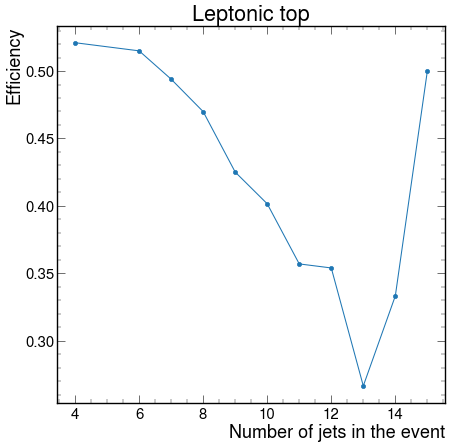

In [59]:
n = [4,6,7,8,9,10,11,12,13,14,15]
plt.plot(n, purities, marker='o')
plt.xlabel("Number of jets in the event")
plt.ylabel("Efficiency")
plt.title("Leptonic top")
plt.show()

## Higgs

In [60]:
purities = []
for n in range(4,16):
    if n == 5:
        continue
    pred_correct, pred_wrong = calculate_efficiency("h", n, jets[ak.num(jets)==n])
    purity = len(pred_correct)/(len(pred_correct)+len(pred_wrong))
    purities.append(purity)

ValueError: in ListArray64 attempting to get 4, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.7.0/src/cpu-kernels/awkward_ListArray_getitem_jagged_apply.cpp#L43)

In [505]:
len(jets[ak.num(jets)==6])

162798

In [500]:
jets_6 = jets[ak.num(jets)==6]
get_higgs_arrays(6, jets_6)

[[1, 5], [2, 5], [0, 4], [1, 3], [2, 4], ... [0, 1], [2, 3], [0, 4], [1, 5], [0, 4]]
[[1, 5], [2, 4], [0, 4], [2, 3], [2, 2], ... [0, 1], [2, 3], [0, 4], [3, 5], [4, 4]]
162798
162798


ValueError: in ListArray64 attempting to get 7, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.7.0/src/cpu-kernels/awkward_ListArray_getitem_jagged_apply.cpp#L43)

In [429]:
purities = []
for n in range(4,16):
    try:
        pred_correct, pred_wrong = calculate_efficiency("h", n, jets[ak.num(jets)==n])
        purity = len(pred_correct)/(len(pred_correct)+len(pred_wrong))
        purities.append(purity)
    except ValueError:
        print(f"For {n} jets, Higgs doesn't exist")

For 4 jets, Higgs doesn't exist
For 5 jets, Higgs doesn't exist
For 6 jets, Higgs doesn't exist
For 7 jets, Higgs doesn't exist
For 8 jets, Higgs doesn't exist
For 9 jets, Higgs doesn't exist
For 10 jets, Higgs doesn't exist
Number of correctly predicted within 11 jets is 163
Number of wrongly predicted within 11 jets is 680
Total within 11 jets is 843
11-jet efficiency is 0.193
Number of correctly predicted within 12 jets is 35
Number of wrongly predicted within 12 jets is 174
Total within 12 jets is 209
12-jet efficiency is 0.167
Number of correctly predicted within 13 jets is 4
Number of wrongly predicted within 13 jets is 41
Total within 13 jets is 45
13-jet efficiency is 0.089
Number of correctly predicted within 14 jets is 2
Number of wrongly predicted within 14 jets is 7
Total within 14 jets is 9
14-jet efficiency is 0.222
Number of correctly predicted within 15 jets is 1
Number of wrongly predicted within 15 jets is 1
Total within 15 jets is 2
15-jet efficiency is 0.500


In [518]:
df = h5py.File('./SPANet/1003_output_v5_full.h5','r')
df_input = h5py.File('./SPANet/data/tth.h5','r')

H_b1_true = ak.Array(df_input["TARGETS"]["h"]["b1"][()])
H_b2_true = ak.Array(df_input["TARGETS"]["h"]["b2"][()])

H_b1_true = ak.unflatten(H_b1_true, ak.ones_like(H_b1_true))
H_b2_true = ak.unflatten(H_b2_true, ak.ones_like(H_b2_true))

H_b1_pred = ak.Array(df["TARGETS"]["h"]["b1"][()])
H_b2_pred = ak.Array(df["TARGETS"]["h"]["b2"][()])

H_b1_pred = ak.unflatten(H_b1_pred, ak.ones_like(H_b1_pred))
H_b2_pred = ak.unflatten(H_b2_pred, ak.ones_like(H_b2_pred))

fields = ['pt','eta','phi','btag']
jets = ak.zip({
    f: df["INPUTS"]["Source"][f][()] for f in fields
}, with_name="Momentum4D")
jets["m"] = np.zeros_like(jets.pt)

jets_input = ak.from_parquet("/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_v6.parquet")
(jets,
partons_matched,
partons,
generator_info,
lepton_partons,
lepton_reco, 
met
) = ak.unzip(jets_input)
jets = ak.with_name(jets, name="Momentum4D")

# Higgs jets full
temp_true_1 = ak.concatenate((H_b1_true, H_b2_true), axis=1)
higgs_index_pred = ak.concatenate((H_b1_pred, H_b2_pred), axis=1)

print(temp_true_1)
print(higgs_index_pred)

print(len(temp_true_1))
print(len(higgs_index_pred))

temp_true_2 = temp_true_1[temp_true_1[:,0] != -1]
higgs_index_true = temp_true_2[temp_true_2[:,1] != -1]

higgs_index_pred = higgs_index_pred[temp_true_1[:,0] != -1]
higgs_index_pred = higgs_index_pred[temp_true_2[:,1] != -1]

print(higgs_index_true)
print(higgs_index_pred)

print(len(higgs_index_true))
print(len(higgs_index_pred))

temp_jets = jets[temp_true_1[:,0] != -1]
temp_jets = temp_jets[temp_true_2[:,1] != -1]

print(len(temp_jets))

#higgs_full_jet_true = temp_jets[higgs_index_true]
#higgs_full_jet_pred = temp_jets[higgs_index_pred]

# Masking to get correct and wrong predictions
#mask = (higgs_full_jet_true == higgs_full_jet_pred)
#higgs_full_pred_correct = higgs_full_jet_pred[mask] # correctly predicted jets
#higgs_full_pred_wrong = higgs_full_jet_pred[~mask] # wrongly predicted jets

# Drop empty arrays
#higgs_full_pred_correct = higgs_full_pred_correct[ak.num(higgs_full_pred_correct)==2]
#higgs_full_pred_wrong = higgs_full_pred_wrong[ak.num(higgs_full_pred_wrong)>0]

[[-1, -1], [1, 5], [1, -1], [2, 5], [3, ... 8], [0, -1], [2, 3], [2, -1], [0, -1]]
[[0, 1], [1, 5], [4, 4], [2, 4], [4, 4], ... [5, 8], [1, 2], [2, 3], [2, 5], [3, 4]]
584143
584143
[[1, 5], [2, 5], [0, 4], [1, 3], [2, 4], ... [2, 4], [0, 4], [0, 5], [1, 8], [2, 3]]
[[1, 5], [2, 4], [0, 4], [2, 3], [2, 2], ... [0, 1], [2, 3], [0, 5], [5, 8], [2, 3]]
350930
350930
350930


In [536]:
temp_jets[higgs_index_true]

<MomentumArray4D [[{pt: 126, eta: 2.37, ... prov: 1}]] type='350930 * var * Mome...'>

In [546]:
for i in range(len(temp_jets)):
    try:
        #print(i)
        #print(higgs_index_pred[i])
        a = temp_jets[higgs_index_pred[i]]
        #print(temp_jets[higgs_index_pred[i]])
    except:
        print("ERROR at ", i)
    #print(temp_jets[higgs_index_pred])

In [554]:

#a = temp_jets[higgs_index_pred]

ValueError: in ListArray64 attempting to get 4, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.7.0/src/cpu-kernels/awkward_ListArray_getitem_jagged_apply.cpp#L43)

In [532]:
#higgs_index_pred[1]
#temp_jets[higgs_index_pred].tolist()
#temp_jets[1][[2,4]].tolist()

[{'pt': 57.96875,
  'eta': 0.604736328125,
  'phi': 2.5654296875,
  'btag': 0.99951171875,
  'm': 0.0,
  'matched': True,
  'prov': 1.0},
 {'pt': 54.8125,
  'eta': 0.600830078125,
  'phi': -2.8134765625,
  'btag': 0.95654296875,
  'm': 0.0,
  'matched': True,
  'prov': 3.0}]

In [512]:
jets[jets.pt>0]

<MomentumArray4D [[{pt: 68.3, eta: 0.853, ... prov: -1}]] type='584143 * var * M...'>

(array([1.75592e+05, 1.60052e+05, 1.20585e+05, 7.65860e+04, 3.41100e+04,
        1.58070e+04, 1.09000e+03, 2.38000e+02, 5.80000e+01, 2.50000e+01]),
 array([-1. ,  0.2,  1.4,  2.6,  3.8,  5. ,  6.2,  7.4,  8.6,  9.8, 11. ]),
 <BarContainer object of 10 artists>)

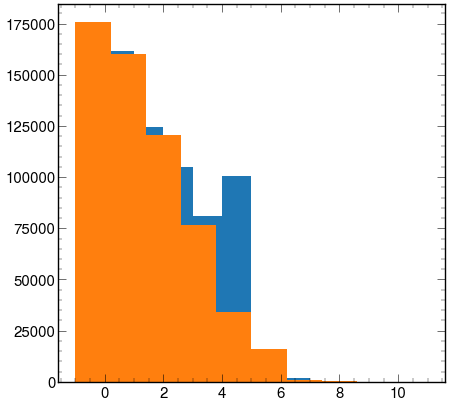

In [460]:
plt.hist(H_b1_pred)
plt.hist(H_b1_true)

## Ignore

In [75]:
pt_arr = df["INPUTS"]["Source"]["pt"][()]
eta_arr = df["INPUTS"]["Source"]["eta"][()]
btag_arr = df["INPUTS"]["Source"]["btag"][()]
phi_arr = df["INPUTS"]["Source"]["phi"][()]

In [72]:
mask = pt_arr>0
pt_arr = pt_arr[mask]
eta_arr = eta_arr[mask]
btag_arr = btag_arr[mask]
phi_arr = phi_arr[mask]

In [97]:
a = ak.zip({"pt": pt_arr, "eta": eta_arr, "btag": btag_arr, "phi": phi_arr},)
a = ak.flatten(a)

In [122]:
pt_arr[0:10]

array([[141.5     , 126.      , 123.8125  , 102.4375  ,  84.375   ,
         42.5625  ,   0.      ],
       [154.875   , 127.875   , 111.125   , 101.5     ,  60.4375  ,
         47.78125 ,  36.6875  ],
       [221.375   , 143.125   ,  72.5625  ,  60.4375  ,  53.28125 ,
         36.5     ,   0.      ],
       [345.75    , 250.25    , 124.      ,  81.0625  ,  59.1875  ,
         43.9375  ,   0.      ],
       [132.75    , 123.      ,  94.6875  ,  85.875   ,  43.6875  ,
         34.6875  ,   0.      ],
       [175.25    ,  89.75    ,  66.25    ,  48.5625  ,  41.78125 ,
         40.59375 ,   0.      ],
       [166.125   ,  91.3125  ,  73.25    ,  68.6875  ,  60.6875  ,
         59.625   ,  34.21875 ],
       [117.625   , 106.5625  ,  79.375   ,  73.875   ,  71.5625  ,
         46.625   ,  38.625   ],
       [140.625   ,  70.125   ,  69.9375  ,  68.125   ,  34.78125 ,
         30.453125,   0.      ],
       [167.125   , 143.625   , 101.1875  ,  77.625   ,  57.34375 ,
         51.125   ,  46

In [173]:
akarr = ak.Array({"pt": pt_arr, "eta": eta_arr})

In [174]:
mydict = {"jets": akarr}
record = ak.Record(mydict)
record.type

{"jets": var * {"pt": var * float64, "eta": var * float64}}

In [175]:
record

<Record ... -2.16, -0.974, -0.213, 0]}]} type='{"jets": var * {"pt": var * float...'>

In [176]:
record.jets

<Array [{pt: [142, 126, 124, ... -0.213, 0]}] type='67876 * {"pt": var * float64...'>

In [187]:
a = ak.unzip(record)
a = ak.with_name(a, name="Momentum4D")

584143 * var * Momentum4D["pt": float32, "eta": float32, "phi": float32, "btag": float32, "m": float64, "matched": bool, "prov": float64]

In [200]:
a

<MomentumArray4D [... -2.16, -0.974, -0.213, 0]}]] type='1 * var * Momentum4D["p...'>

In [109]:
akarr = ak.Array({"pt": [pt_arr[0], pt_arr[-1]], "eta": [eta_arr[0], eta_arr[-1]]})
mydict = {"jets":  akarr} 
record = ak.Record(mydict)
record

<Record ... -2.16, -0.974, -0.213, 0]}]} type='{"jets": var * {"pt": var * float...'>

In [92]:
a[1].tolist()

{'pt': 126.0, 'eta': 2.365234375, 'btag': 0.99609375, 'phi': -2.8564453125}

In [56]:
ak.unzip(df["INPUTS"]["Source"][f][()] for f in fields)[0]

<generator object <genexpr> at 0x7f61aa8f7660>

In [ ]:
jets = ak.zip({
    f: df["INPUTS"]["Source"][f][()] for f in fields
}, with_name="Momentum4D")
jets["m"] = np.zeros_like(jets.pt)
jets[0].tolist()

In [43]:
jets = ak.with_name(jets, name="Momentum4D")
jets

<MomentumArray4D [[{pt: 142, eta: 1.5, ... m: 0}]] type='67876 * 7 * Momentum4D[...'>

(array([    0.,     0.,     0.,     0.,     0., 67876.,     0.,     0.,
            0.,     0.]),
 array([6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5]),
 <BarContainer object of 10 artists>)

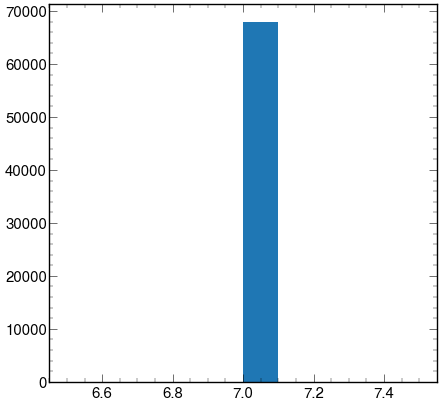

In [40]:
#a = leptop_pred_correct[leptop_pred_correct.pt>0] 
#a = ak.flatten(a, axis=0)
#jets_6 = a[ak.num(a) == 6]
plt.hist(ak.num(jets))

In [40]:
# Higgs jets full
higgs_index_true = ak.concatenate((H_b1_true, H_b2_true), axis=1)
higgs_full_jet_true = jets[higgs_index_true]

higgs_index_pred = ak.concatenate((H_b1_pred, H_b2_pred), axis=1)
higgs_full_jet_pred = jets[higgs_index_pred]

# Higgs 6 jets 
higgs_index_true = ak.concatenate((H_b1_true, H_b2_true), axis=1)
higgs_index_true = higgs_index_true[ak.num(jets)==6]
higgs_6_jet_true = jets_6[higgs_index_true]

higgs_index_pred = ak.concatenate((H_b1_pred, H_b2_pred), axis=1)
higgs_index_pred = higgs_index_pred[ak.num(jets)==6]
higgs_6_jet_pred = jets_6[higgs_index_pred]

# Higgs 7 jets 
higgs_index_true = ak.concatenate((H_b1_true, H_b2_true), axis=1)
higgs_index_true = higgs_index_true[ak.num(jets)==7]
higgs_7_jet_true = jets_7[higgs_index_true]

higgs_index_pred = ak.concatenate((H_b1_pred, H_b2_pred), axis=1)
higgs_index_pred = higgs_index_pred[ak.num(jets)==7]
higgs_7_jet_pred = jets_7[higgs_index_pred]

# Masking to get correct and wrong predictions
mask = (higgs_full_jet_true == higgs_full_jet_pred)
higgs_full_pred_correct = higgs_full_jet_pred[mask] # correctly predicted jets
higgs_full_pred_wrong = higgs_full_jet_pred[~mask] # wrongly predicted jets

# Drop empty arrays
higgs_full_pred_correct = higgs_full_pred_correct[ak.num(higgs_full_pred_correct)==2]
higgs_full_pred_wrong = higgs_full_pred_wrong[ak.num(higgs_full_pred_wrong)>0]

mask = (higgs_6_jet_true == higgs_6_jet_pred)
higgs_6_pred_correct = higgs_6_jet_pred[mask] # correctly predicted jets
higgs_6_pred_wrong = higgs_6_jet_pred[~mask] # wrongly predicted jets

# Drop empty arrays
higgs_6_pred_correct = higgs_6_pred_correct[ak.num(higgs_6_pred_correct)==2]
higgs_6_pred_wrong = higgs_6_pred_wrong[ak.num(higgs_6_pred_wrong)>0]

mask = (higgs_7_jet_true == higgs_7_jet_pred)
higgs_7_pred_correct = higgs_7_jet_pred[mask] # correctly predicted jets
higgs_7_pred_wrong = higgs_7_jet_pred[~mask] # wrongly predicted jets

# Drop empty arrays
higgs_7_pred_correct = higgs_7_pred_correct[ak.num(higgs_7_pred_correct)==2]
higgs_7_pred_wrong = higgs_7_pred_wrong[ak.num(higgs_7_pred_wrong)>0]

NameError: name 'H_b1_true' is not defined

In [48]:
# t1 jets full
t1_index_true = ak.concatenate((t1_q1_true, t1_q2_true, t1_b_true), axis=1)
t1_full_jet_true = jets[t1_index_true]

t1_index_pred = ak.concatenate((t1_q1_pred, t1_q2_pred, t1_b_pred), axis=1)
t1_full_jet_pred = jets[t1_index_pred]

# t1 6 jets 
t1_index_true = ak.concatenate((t1_q1_true, t1_q2_true, t1_b_true), axis=1)
t1_index_true = t1_index_true[ak.num(jets)==6]
t1_6_jet_true = jets_6[t1_index_true]

t1_index_pred = ak.concatenate((t1_q1_pred, t1_q2_pred, t1_b_pred), axis=1)
t1_index_pred = t1_index_pred[ak.num(jets)==6]
t1_6_jet_pred = jets_6[t1_index_pred]

# t1 7 jets 
t1_index_true = ak.concatenate((t1_q1_true, t1_q2_true, t1_b_true), axis=1)
t1_index_true = t1_index_true[ak.num(jets)==7]
t1_7_jet_true = jets_7[t1_index_true]

t1_index_pred = ak.concatenate((t1_q1_pred, t1_q2_pred, t1_b_pred), axis=1)
t1_index_pred = t1_index_pred[ak.num(jets)==7]
t1_7_jet_pred = jets_7[t1_index_pred]

# Masking to get correct and wrong predictions
mask = (t1_full_jet_true == t1_full_jet_pred)
t1_full_pred_correct = t1_full_jet_pred[mask] # correctly predicted jets
t1_full_pred_wrong = t1_full_jet_pred[~mask] # wrongly predicted jets

# Drop empty arrays
t1_full_pred_correct = t1_full_pred_correct[ak.num(t1_full_pred_correct)==3]
t1_full_pred_wrong = t1_full_pred_wrong[ak.num(t1_full_pred_wrong)>0]

mask = (t1_6_jet_true == t1_6_jet_pred)
t1_6_pred_correct = t1_6_jet_pred[mask] # correctly predicted jets
t1_6_pred_wrong = t1_6_jet_pred[~mask] # wrongly predicted jets

# Drop empty arrays
t1_6_pred_correct = t1_6_pred_correct[ak.num(t1_6_pred_correct)==3]
t1_6_pred_wrong = t1_6_pred_wrong[ak.num(t1_6_pred_wrong)>0]

mask = (t1_7_jet_true == t1_7_jet_pred)
t1_7_pred_correct = t1_7_jet_pred[mask] # correctly predicted jets
t1_7_pred_wrong = t1_7_jet_pred[~mask] # wrongly predicted jets

# Drop empty arrays
t1_7_pred_correct = t1_7_pred_correct[ak.num(t1_7_pred_correct)==3]
t1_7_pred_wrong = t1_7_pred_wrong[ak.num(t1_7_pred_wrong)>0]

NameError: name 't1_q1_true' is not defined

In [ ]:
from collections import Counter

def pt_efficiency(true_pt, pred_pt):
    pt_arr = np.linspace(30, 800, 100)

    # bin the data into 100 equally spaced bins
    #bins = np.linspace(30, 800, 101)

    # use the histogram function to count the number of elements in each bin
    #hist, edges = np.histogram(pt_arr, bins)
    
    #indices = np.digitize(pred_pt, bins)
    #indices = indices - 1
    #print(indices)
    #binned_pred_pt = np.zeros(len(indices))
    #for i in range(len(indices)):
        #bin_idx = indices[i] - 1  # subtract 1 to convert from 1-based to 0-based index
        #binned_pred_pt[bin_idx] += pt_arr[i]

    #print(binned_pred_pt)
    
    bins = create_bins(lower_bound=0, width=8, quantity=100)
    binned_pred_pt = []
    for value in pred_pt:
        bin_index = find_bin(value, bins)
        #print(value, bin_index, bins[bin_index])
        binned_pred_pt.append(bin_index)
    
    #print(binned_pred_pt)
    
    frequencies = dict(Counter(binned_pred_pt))
    #print(frequencies)
    
    #plt.hist()
    #return dict(frequencies)
    return binned_pred_pt

def pt_efficiency(a, true_pt, pred_pt, pred_pt_correct):
    intervals = create_bins(lower_bound=0, width=8,quantity=100)
    counts = a.values() # correspond directly to intervals
    
    count = 0
    for i in range(len(pred_pt)):
        if pred_pt[i] in pred_pt_correct:
            count += 1
    print(count)
    return 0